# Age Estimation and Gender Classification Using CNNs
This notebook documents my project focused on predicting a person's age and gender based on facial images using convolutional neural networks (CNNs). The goal is to explore two distinct approaches to tackle this problem:
- Model A: A CNN built from scratch that learns features directly from the training data. The final model is saved as age_gender_A.keras.
- Model B: A CNN that leverages transfer learning by fine-tuning a pre-trained model. This approach benefits from previously learned feature representations and is saved as age_gender_B.keras.

## Dataset
The experiments are conducted on a subset of the UTKFace dataset, comprising 23708 labeled face images. Each image has been resized to 128 x 128 pixels, and the data is organized in the Dataset/ directory. The models will later be evaluated on unseen test data to assess their generalization performance.

## Performance Metrics
To quantify the models' performance, the following metrics will be used:

- Age Estimation: Evaluated using Mean Absolute Error (MAE).
- Gender Prediction: Evaluated based on accuracy.


## Importing Libraries and Setting Up the Environment

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

## Get The Data - Data is downloaded from Kagglehub

In [2]:
# # Importing the data from Kaggle using kagglehub
# import kagglehub

# # Download and get the path to the UTKFace dataset
# path = kagglehub.dataset_download("jangedoo/utkface-new")
# print("Path to dataset files:", path)

# path = os.path.join(path, "UTKFace")

path = "./Dataset/UTKFace"

In [3]:
# Set target image size and other parameters
IMG_HEIGHT, IMG_WIDTH = 128, 128  
BATCH_SIZE = 32
EPOCHS = 10  


In [4]:
# Initialize lists to hold image data and labels
images = []
ages = []
genders = []

# Loop over each file in the dataset folder
for filename in os.listdir(path):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        # The filename format is usually: age_gender_race_date.jpg
        try:
            parts = filename.split('_')
            age = int(parts[0])
            gender = int(parts[1])  # Typically 0 for male and 1 for female
        except Exception as e:
            print(f"Skipping file {filename} due to error: {e}")
            continue

        # Load image with the specified target size
        img_path = os.path.join(path, filename)
        img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img = img_to_array(img)
        images.append(img)
        ages.append(age)
        genders.append(gender)

# Convert lists to numpy arrays
images = np.array(images, dtype="float32")
ages = np.array(ages, dtype="float32")
genders = np.array(genders, dtype="float32")

In [5]:

# Normalize the image pixel values to [0, 1]
images /= 255.0

print("Dataset shapes:")
print("Images:", images.shape)
print("Ages:", ages.shape)
print("Genders:", genders.shape)


Dataset shapes:
Images: (23708, 128, 128, 3)
Ages: (23708,)
Genders: (23708,)


### Splitting the Dataset

In [6]:

# Split the dataset into training and testing sets
X_train, X_test, y_age_train, y_age_test, y_gender_train, y_gender_test = train_test_split(
    images, ages, genders, test_size=0.2, random_state=42)


## Model A - Creating a model from scratch    

In [7]:
input_layer = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Convolutional Layers
conv_1 = layers.Conv2D(32, (3, 3), activation='relu')(input_layer)
maxp_1 = layers.MaxPooling2D((2, 2))(conv_1)
conv_2 = layers.Conv2D(64, (3, 3), activation='relu')(maxp_1)
maxp_2 = layers.MaxPooling2D((2, 2))(conv_2)
conv_3 = layers.Conv2D(128, (3, 3), activation='relu')(maxp_2)
maxp_3 = layers.MaxPooling2D((2, 2))(conv_3)
conv_4 = layers.Conv2D(128, (3, 3), activation='relu')(maxp_3)
maxp_4 = layers.MaxPooling2D((2, 2))(conv_4)

# Flatten the output of the convolutional layers
flatten = layers.Flatten()(maxp_4)

# Fully connected layers
dense_1 = layers.Dense(256, activation='relu')(flatten)
drop_1 = layers.Dropout(0.3)(dense_1)

dense_2 = layers.Dense(256, activation='relu')(flatten)
drop_2 = layers.Dropout(0.3)(dense_2)

# Output layers
gender_output = Dense(1, activation='sigmoid', name='gender_output')(drop_1)
age_output = Dense(1, activation='linear', name='age_output')(drop_2)


modelA = Model(inputs=input_layer, outputs=[age_output, gender_output])
modelA.summary()




Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 63, 63, 32)   0           ['conv2d[0][0]']                 
                                                                                              

### Model A - Compiling and Training the Model

In [8]:
# Compile the model with different loss functions for each output
modelA.compile(
    optimizer='adam',
    loss={'age_output': 'mse', 'gender_output': 'binary_crossentropy'},
    metrics={'age_output': 'mae', 'gender_output': 'accuracy'}
)

# Train the model
history = modelA.fit(
    X_train,
    {'age_output': y_age_train, 'gender_output': y_gender_train},
    validation_data=(X_test, {'age_output': y_age_test, 'gender_output': y_gender_test}),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)


modelA.save("./trained models/age_gender_A.keras")

Epoch 1/10
593/593 [==============================] - 21s 23ms/step - loss: 377.4668 - age_output_loss: 376.7963 - gender_output_loss: 0.6705 - age_output_mae: 14.8066 - gender_output_accuracy: 0.5876 - val_loss: 224.4177 - val_age_output_loss: 223.8833 - val_gender_output_loss: 0.5344 - val_age_output_mae: 11.1941 - val_gender_output_accuracy: 0.7613
Epoch 2/10
593/593 [==============================] - 11s 19ms/step - loss: 204.1021 - age_output_loss: 203.6059 - gender_output_loss: 0.4963 - age_output_mae: 10.7607 - gender_output_accuracy: 0.7580 - val_loss: 167.2838 - val_age_output_loss: 166.8363 - val_gender_output_loss: 0.4476 - val_age_output_mae: 9.3918 - val_gender_output_accuracy: 0.7902
Epoch 3/10
593/593 [==============================] - 11s 19ms/step - loss: 145.0047 - age_output_loss: 144.5674 - gender_output_loss: 0.4373 - age_output_mae: 8.9889 - gender_output_accuracy: 0.7932 - val_loss: 120.6303 - val_age_output_loss: 120.2369 - val_gender_output_loss: 0.3933 - val_a

### Plot Model A metrics

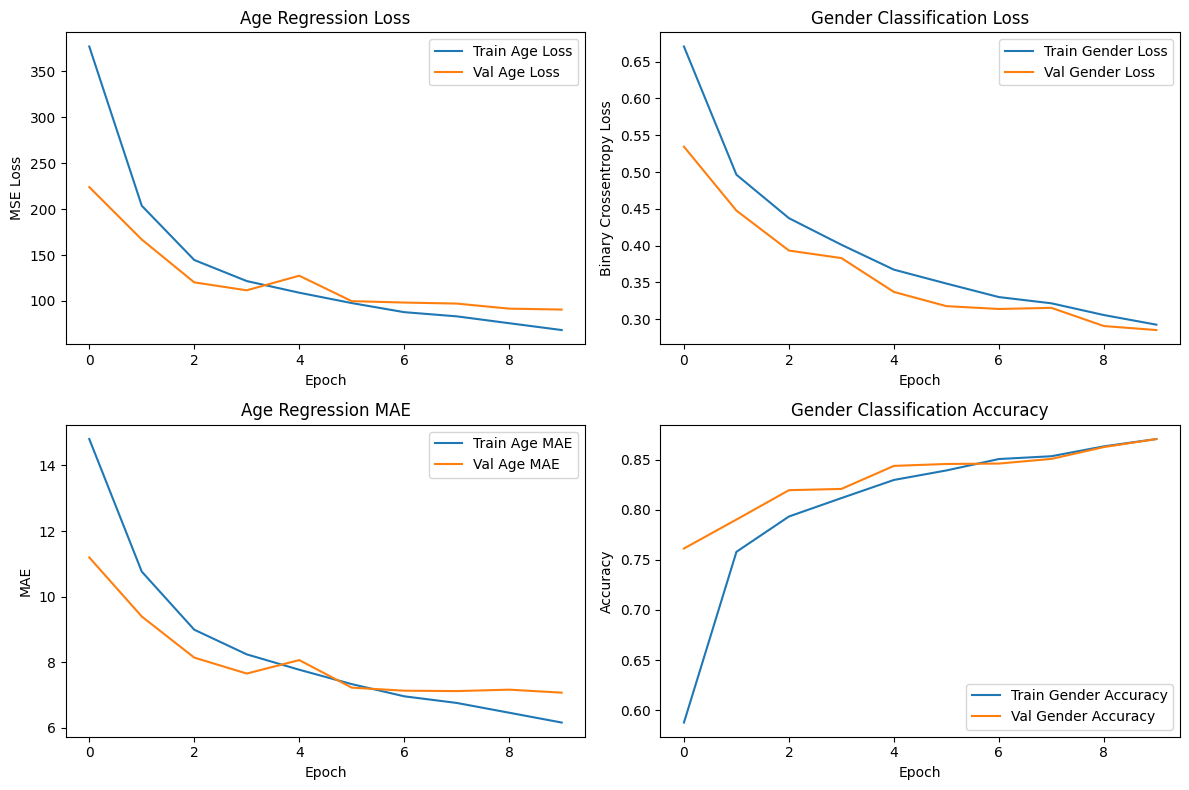

In [9]:
plt.figure(figsize=(12, 8))

# Age Loss (MSE)
plt.subplot(2, 2, 1)
plt.plot(history.history['age_output_loss'], label='Train Age Loss')
plt.plot(history.history['val_age_output_loss'], label='Val Age Loss')
plt.title('Age Regression Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()

# Gender Loss (Binary Crossentropy)
plt.subplot(2, 2, 2)
plt.plot(history.history['gender_output_loss'], label='Train Gender Loss')
plt.plot(history.history['val_gender_output_loss'], label='Val Gender Loss')
plt.title('Gender Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Binary Crossentropy Loss')
plt.legend()

# Age MAE
plt.subplot(2, 2, 3)
plt.plot(history.history['age_output_mae'], label='Train Age MAE')
plt.plot(history.history['val_age_output_mae'], label='Val Age MAE')
plt.title('Age Regression MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# Gender Accuracy
plt.subplot(2, 2, 4)
plt.plot(history.history['gender_output_accuracy'], label='Train Gender Accuracy')
plt.plot(history.history['val_gender_output_accuracy'], label='Val Gender Accuracy')
plt.title('Gender Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Model B - Transfer Learning Using MobileNetV2

In [10]:
# Input layer: 128 x 128 x 3
input_tensor = Input(shape=(128, 128, 3))

# Load pre-trained MobileNetV2 with ImageNet weights, excluding the top layers
base_model = MobileNetV2(input_tensor=input_tensor, include_top=False, weights='imagenet')

# Optionally, freeze the base model layers to use them as fixed feature extractors
for layer in base_model.layers:
    layer.trainable = False

# Use a GlobalAveragePooling2D layer to reduce the spatial dimensions
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a shared fully connected layer with dropout to prevent overfitting
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
shared = Dense(128, activation='relu')(x)

# Age Prediction Branch (Regression)
age_branch = Dense(64, activation='relu')(shared)
age_output = Dense(1, activation='linear', name='age_output')(age_branch)

# Gender Classification Branch (Binary classification with a single output unit)
gender_branch = Dense(64, activation='relu')(shared)
gender_output = Dense(1, activation='sigmoid', name='gender_output')(gender_branch)

# Define the multi-output model
modelB = Model(inputs=input_tensor, outputs=[age_output, gender_output])

# Display the model architecture summary
modelB.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

### Model B - Compiling and Training the Model

In [11]:

# ---------------------------
# Compile modelB
# ---------------------------
modelB.compile(
    optimizer='adam',
    loss={
        'age_output': 'mse',
        'gender_output': 'binary_crossentropy'
    },
    metrics={
        'age_output': 'mae',
        'gender_output': 'accuracy'
    }
)

# ---------------------------
# Train modelB using your training and validation data
# ---------------------------
historyB = modelB.fit(
    X_train,  # Training images
    {'age_output': y_age_train, 'gender_output': y_gender_train},  # Corresponding age and gender labels
    validation_data=(X_test, {'age_output': y_age_test, 'gender_output': y_gender_test}),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

modelB.save("./trained models/age_gender_B.keras")


Epoch 1/10
593/593 [==============================] - 13s 18ms/step - loss: 194.7302 - age_output_loss: 194.0173 - gender_output_loss: 0.7128 - age_output_mae: 10.2644 - gender_output_accuracy: 0.6249 - val_loss: 157.9989 - val_age_output_loss: 157.4107 - val_gender_output_loss: 0.5883 - val_age_output_mae: 9.0713 - val_gender_output_accuracy: 0.6841
Epoch 2/10
593/593 [==============================] - 9s 15ms/step - loss: 153.2497 - age_output_loss: 152.6204 - gender_output_loss: 0.6293 - age_output_mae: 9.0387 - gender_output_accuracy: 0.6644 - val_loss: 195.0756 - val_age_output_loss: 194.4492 - val_gender_output_loss: 0.6263 - val_age_output_mae: 10.3121 - val_gender_output_accuracy: 0.6116
Epoch 3/10
593/593 [==============================] - 9s 15ms/step - loss: 145.0616 - age_output_loss: 144.4398 - gender_output_loss: 0.6219 - age_output_mae: 8.7424 - gender_output_accuracy: 0.6613 - val_loss: 170.2503 - val_age_output_loss: 169.6712 - val_gender_output_loss: 0.5792 - val_age_

### Plot model B metrics

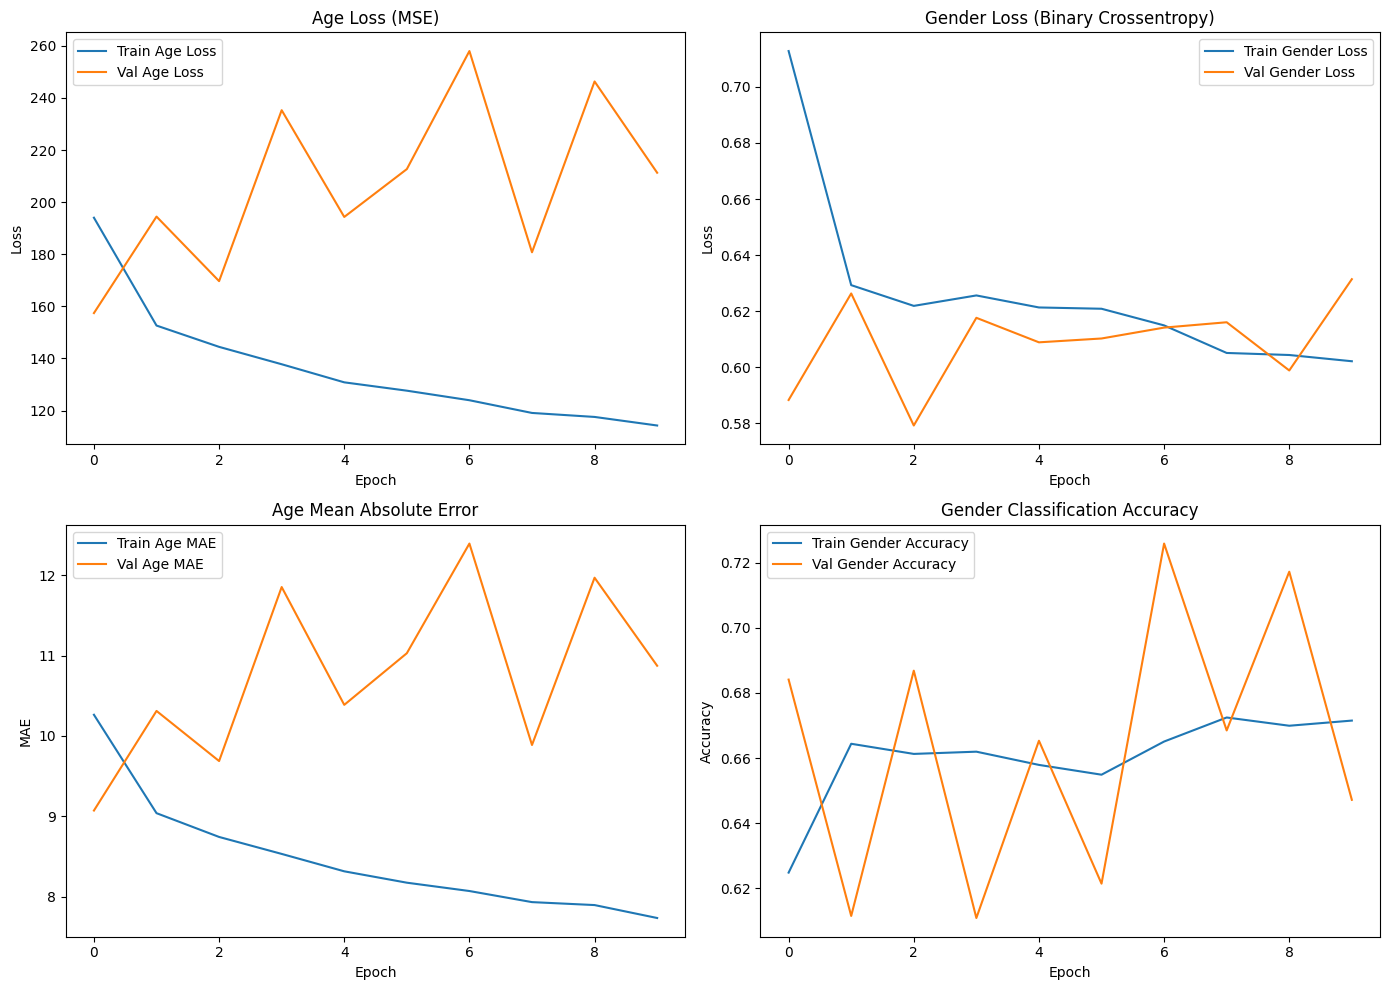

In [12]:
plt.figure(figsize=(14, 10))

# ---------------------------
# Plot Age Loss (MSE)
# ---------------------------
plt.subplot(2, 2, 1)
plt.plot(historyB.history['age_output_loss'], label='Train Age Loss')
plt.plot(historyB.history['val_age_output_loss'], label='Val Age Loss')
plt.title('Age Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# ---------------------------
# Plot Gender Loss (Binary Crossentropy)
# ---------------------------
plt.subplot(2, 2, 2)
plt.plot(historyB.history['gender_output_loss'], label='Train Gender Loss')
plt.plot(historyB.history['val_gender_output_loss'], label='Val Gender Loss')
plt.title('Gender Loss (Binary Crossentropy)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# ---------------------------
# Plot Age MAE
# ---------------------------
plt.subplot(2, 2, 3)
plt.plot(historyB.history['age_output_mae'], label='Train Age MAE')
plt.plot(historyB.history['val_age_output_mae'], label='Val Age MAE')
plt.title('Age Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

# ---------------------------
# Plot Gender Accuracy
# ---------------------------
plt.subplot(2, 2, 4)
plt.plot(historyB.history['gender_output_accuracy'], label='Train Gender Accuracy')
plt.plot(historyB.history['val_gender_output_accuracy'], label='Val Gender Accuracy')
plt.title('Gender Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Predicting on Test Images and Displaying Results

Found 25 images for prediction.
1/1 [==============================] - 0s 15ms/step


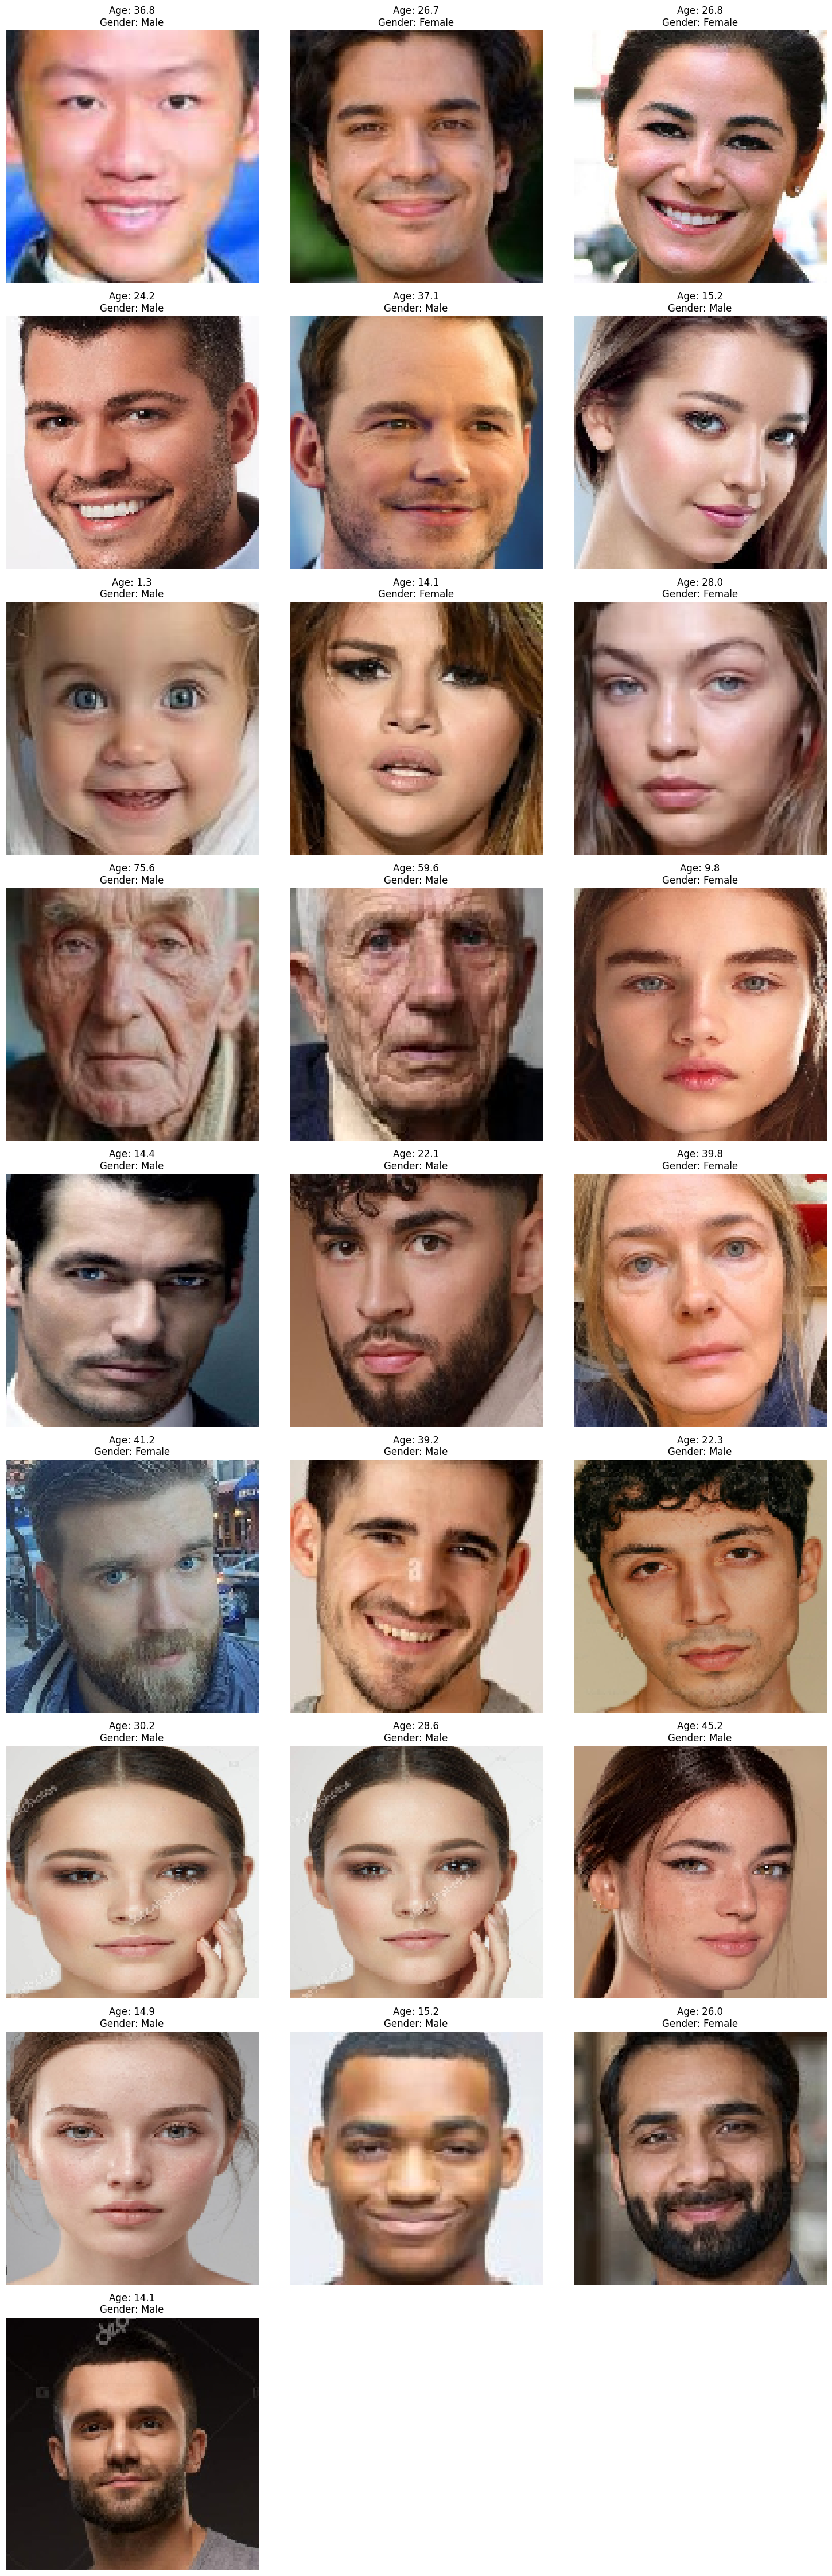

In [14]:
# Define the directory containing the test images
test_images_dir = "./Dataset/test images" # path to the test images

# List all image files in the directory (adjust extensions as needed)
image_files = [os.path.join(test_images_dir, f) 
               for f in os.listdir(test_images_dir) 
               if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

print(f"Found {len(image_files)} images for prediction.")

# Define grid layout for displaying images
n_cols = 3
n_rows = (len(image_files) + n_cols - 1) // n_cols
plt.figure(figsize=(n_cols * 5, n_rows * 5))

# Loop over each image, predict, and plot the result
for i, image_path in enumerate(image_files):
    # Load and preprocess the image
    img = load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = tf.expand_dims(img_array, 0)  # Add batch dimension

    # Make predictions with your model
    predictions = modelA.predict(img_array) # change to modelA or modelB
    predicted_age = predictions[0].flatten()[0]
    predicted_gender = predictions[1].flatten()[0]
    pred_gender_label = "Female" if predicted_gender >= 0.5 else "Male"

    # Plot the image with its predicted age and gender
    plt.subplot(n_rows, n_cols, i + 1)
    plt.imshow(load_img(image_path, target_size=(IMG_HEIGHT, IMG_WIDTH)))
    plt.title(f"Age: {predicted_age:.1f}\nGender: {pred_gender_label}")
    plt.axis("off")

plt.tight_layout()
plt.show()
